In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from abc import ABC, abstractmethod
from scipy.stats import invwishart
plt.style.use('dark_background')

In [2]:
# this can be compiled
@jit(nopython=True)
def forward(prob,A,P):
    '''
    Forward algorithm for the HMM
    prob: numpy (n,n_states) array with
        the probability of each observation
        for each state
    A: numpy (n_states,n_states) array with the state
        transition matrix
    P: numpy (n_states,) array with the initial
        state probability
    returns:
        alpha: numpy (n,n_states) array meaning
            p(state=i|obs <= i)
        c: numpy (n,) array with the normalization
            constants
    '''
    n_obs=prob.shape[0]
    n_states=prob.shape[1]
    alpha=np.zeros((n_obs,n_states),dtype=np.float64)
    c=np.zeros(n_obs,dtype=np.float64)
    alpha[0]=P*prob[0]
    c[0]=1/np.sum(alpha[0])
    alpha[0]*=c[0]
    for i in range(1,n_obs):
        alpha[i]=np.dot(A.T,alpha[i-1])*prob[i] 
        c[i]=1/np.sum(alpha[i])
        alpha[i]*=c[i]
    return alpha,c

# this can be compiled
@jit(nopython=True)
def backward_sample(A,alpha,q,transition_counter,init_state_counter):
    '''
    Backward sample from the state transition matrix and state sequence
    A: numpy (n_states,n_states) array with the state
        transition matrix
    alpha: numpy (n,n_states) array meaning
        p(state=i|obs <= i)		
    q: numpy (n,) to store the sample of state sequence
    transition_counter: numpy (n_states,n_states) array to store 
        transition counts to be used to sample a state transition 
        matrix
    init_state_counter: numpy (n_states,) array to store the
        number of times state i is the initial one
    returns:
        none (q and transition_counter are changed inside this function)
    '''	
    # backward walk to sample from the state sequence
    n=q.size
    # sample the last hidden state with probability alpha[-1]
    q[n-1]=np.searchsorted(np.cumsum(alpha[-1]),np.random.random(),side="right")#]
    # aux variable
    p=np.zeros(A.shape[0],dtype=np.float64)
    # iterate backwards
    for j in range(n-2,-1,-1):
        # from formula
        p=A[:,q[j+1]]*alpha[j] 
        # normalize (from formula)
        p/=np.sum(p) 
        # sample hidden state with probability p
        q[j]=np.searchsorted(np.cumsum(p),np.random.random(),side="right")
        # increment transition counter (we can do this calculation incrementally)
        transition_counter[q[j],q[j+1]]+=1 
    # increment initial state counter
    init_state_counter[q[0]]+=1

In [3]:


class Emission(ABC):
    
    @abstractmethod
    def view(self, plot_hist:bool = False):
        """Subclasses must implement this method"""
        pass        
        
    @abstractmethod
    def set_gibbs_parameters(self, n_gibbs:int, f_burn:float, n_gibbs_sim:int = None):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod
    def gibbs_initialize(self, y:np.ndarray, x:np.ndarray = None, **kwargs):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod        
    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod
    def gibbs_burn_and_mean(self):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod
    def gibbs_prob(self, y:np.ndarray, x:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass
    
def mvgauss_prob(x,mean,cov_inv,cov_det):
    '''
    x: numpy (n,p) array 
        each row is a joint observation
    mean: numpy (p,) array with the location parameter
    cov_inv: numpy(p,p) array with the inverse covariance 
            can be computed with np.linalg.inv(cov)
    cov_det: scalar with the determinant of the covariance matrix 
            can be computed with np.linalg.det(cov)
    returns:
        out: numpy(n,) array where each value out[i] is the 
                probability of observation x[i] 
    '''
    k=mean.size # number of variables
    x_c=x-mean # center x
    # vectorized computation
    return np.exp(-0.5*np.sum(x_c*np.dot(x_c,cov_inv),axis=1))/np.sqrt(np.power(2*np.pi,k)*cov_det)    


** Gaussian Emission **
Mean
[1.01194297]
Covariance
[[0.97962762]]



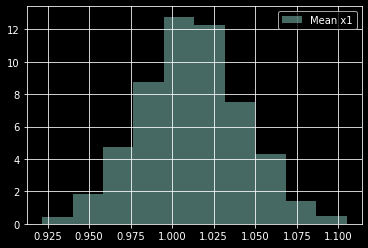

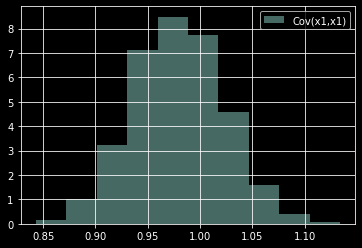

In [4]:
    
class GaussianEmission(Emission):
    
    def __init__(self, n_gibbs:int = 100, f_burn:float = 0.1, max_k = 0.1):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.max_k = max_k
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))        
        self.p = 1
        self.gibbs_cov = None
        self.gibbs_mean = None
        self.cov = None
        self.mean = None
        
        # auxiliar parameters
        self.S0aux = None
        self.invV0, self.invV0m0 = None, None
        self.prev_mn, self.prev_Vn, self.prev_vn, self.prev_Sn = None, None, None, None 

    def view(self, plot_hist = False):
        print('** Gaussian Emission **')
        print('Mean')
        print(self.mean)
        print('Covariance')
        print(self.cov)
        print()
        if plot_hist:
            if self.gibbs_mean is not None:
                for i in range(self.p):
                    plt.hist(
                            self.gibbs_mean[:,i],
                            density=True,
                            alpha=0.5,
                            label='Mean x%s'%(i+1)
                            )
                plt.legend()
                plt.grid(True)
                plt.show()
            if self.gibbs_cov is not None:
                for i in range(self.p):
                    for j in range(i,self.p):
                        plt.hist(
                                self.gibbs_cov[:,i,j],
                                density=True,
                                alpha=0.5,
                                label='Cov(x%s,x%s)'%(i+1,j+1)
                                )
                plt.legend()
                plt.grid(True)
                plt.show()

    def set_gibbs_parameters(self, n_gibbs, f_burn, n_gibbs_sim = None):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        aux = int(self.n_gibbs*(1+self.f_burn))
        self.n_gibbs_sim = aux if n_gibbs_sim is None else n_gibbs_sim
            
    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 2, "y must be a matrix"
        self.p = y.shape[1]
        # Covariance samples
        self.gibbs_cov = np.zeros((self.n_gibbs_sim,self.p,self.p)) 
        # Mean samples
        self.gibbs_mean = np.zeros((self.n_gibbs_sim,self.p))  
        # this will be updated later
        self.cov = np.eye(self.p)
        self.mean = np.zeros(self.p)

        # compute data covariance
        c=np.cov(y.T)
        # fix when y has only one column
        if c.ndim==0:
            c=np.array([[c]])
        # diagonal matrix with the covariances
        c_diag=np.diag(np.diag(c))         
        # Prior distribution parameters
        # these parameters make sense for the type of problems
        # we are trying to solve - assuming zero correlation makes sense
        # as a prior and zero means as well due to the low 
        # values of financial returns
        m0 = np.mean(y, axis = 0) # mean: prior location (just put it at zero...)
        V0 = c_diag.copy() # mean: prior covariance
        self.S0aux = c_diag.copy() # covariance prior scale (to be multiplied later)        
        self.invV0 = np.linalg.inv(V0)
        self.invV0m0 = np.dot(self.invV0, m0)    
        
        # initialize
        self.gibbs_mean[0] = m0
        self.gibbs_cov[0] = c          
        
        # store parameters
        self.prev_mn = m0
        self.prev_Vn = V0
        self.prev_vn = self.p+1+1
        self.prev_Sn = self.S0aux

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        '''
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        if y.shape[0] == 0:
            self.gibbs_mean[iteration] = np.random.multivariate_normal(self.prev_mn, self.prev_Vn)
            self.gibbs_cov[iteration] = invwishart.rvs(df = self.prev_vn, scale = self.prev_Sn)  
        else:
            n = y.shape[0]
            y_mean_ = np.mean(y, axis=0)
            # Sample from mean
            invC = np.linalg.inv(self.gibbs_cov[iteration-1])
            Vn = np.linalg.inv(self.invV0 + n*invC)
            mn = np.dot(Vn, self.invV0m0 + n*np.dot(invC,y_mean_))
            self.prev_mn = mn
            self.prev_Vn = Vn
            self.gibbs_mean[iteration] = np.random.multivariate_normal(mn, Vn)
            # Sample from cov
            # Get random k value (shrinkage value)
            k = np.random.uniform(0, self.max_k)
            n0 = k*n
            S0 = n0*self.S0aux
            v0 = n0 + self.p + 1
            vn = v0 + n
            St = np.dot((y-self.gibbs_mean[iteration]).T,(y-self.gibbs_mean[iteration]))
            Sn = S0 + St
            self.prev_vn = vn
            self.prev_Sn = Sn
            self.gibbs_cov[iteration] = invwishart.rvs(df = vn, scale = Sn)	        
    
    def gibbs_burn_and_mean(self):
        self.gibbs_mean = self.gibbs_mean[-self.n_gibbs:,:]
        self.gibbs_cov = self.gibbs_cov[-self.n_gibbs:,:,:]        
        self.mean = np.mean(self.gibbs_mean,axis=0)
        self.cov = np.mean(self.gibbs_cov,axis=0)	
    
    def estimate(self, y:np.ndarray, **kwargs):
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()        
        
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        cov_inv = np.linalg.inv(self.gibbs_cov[iteration-1])
        cov_det = np.linalg.det(self.gibbs_cov[iteration-1])
        # use vectorized function
        return mvgauss_prob(y, self.gibbs_mean[iteration-1], cov_inv, cov_det)  
    
x = np.random.normal(1,1,1000)    
y = x[:,None]
n_gibbs = 1000
ge = GaussianEmission(n_gibbs = n_gibbs)    
ge.estimate(y)
ge.view(True)

** Gaussian HMM **
Groups
States 0 have the same emission
States 1 have the same emission
Initial state probability
[0.8007796 0.1992204]


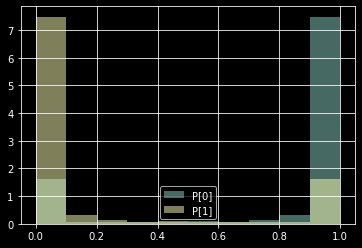

State transition matrix
[[0.928 0.072]
 [0.113 0.887]]



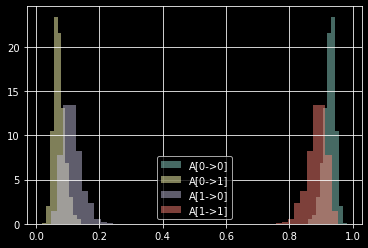

** Gaussian Emission **
Mean
[0.10093719]
Covariance
[[0.13440587]]



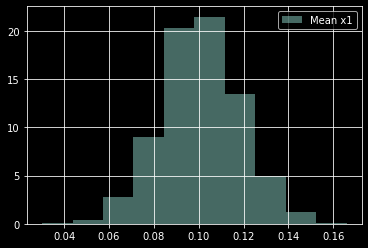

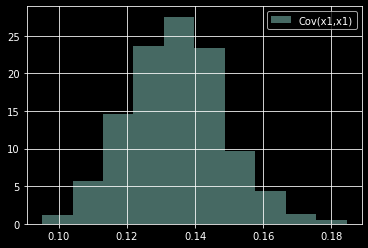

** Gaussian Emission **
Mean
[-0.15555669]
Covariance
[[0.52971985]]



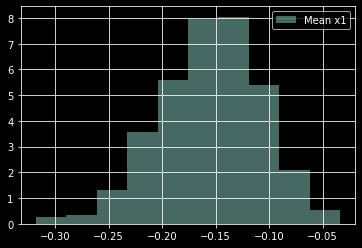

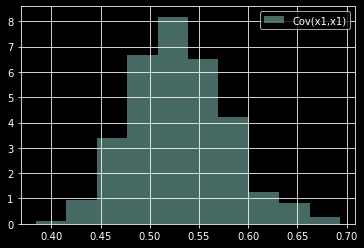

In [42]:

class HMM(object):
    
    def __init__(
                self,
                emissions = [],                
                n_gibbs = 1000,
                A_zeros = [],
                emissions_indexes = [],
                f_burn = 0.1,
                **kwargs
                ):
        '''
        emissions: list of instances derived from Emission
                one for each state
        n_gibbs: number of gibbs samples
        A_zeros: list of lists with entries of A to be set to zero
        emissions_indexes: list of lists
            example
                    emissions_indexes = [[0,2],[1,3]]
                means 
                    emission[0] is applied to states 0 and 2
                    emission[1] is applied to states 1 and 3
                also, this implies that the number of states is 4!
        f_burn: fraction to burn  
        '''
        self.emissions = emissions   
               
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        
        self.A_zeros = A_zeros
        
        self.emissions_indexes = emissions_indexes 
        if len(self.emissions_indexes) == 0:
            self.n_states = len(self.emissions)
            self.emissions_indexes = [[e] for e in range(self.n_states)]   
        
        self.n_states = 0 
        for e in self.emissions_indexes: self.n_states += len(e)
        self.eff_n_states = len(self.emissions_indexes)    
        assert self.eff_n_states == len(self.emissions), "emissions do not match groups"
        # real number of samples to simulate
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.p = 1
        self.P = None
        self.gibbs_P = None
        self.A = None
        self.gibbs_A = None
        self.w_norm = 1
        # **
        for emission in self.emissions:
            emission.set_gibbs_parameters(self.n_gibbs, self.f_burn, self.n_gibbs_sim)
        # **
        # Dirichelet prior parameters
        self.ALPHA = 1
        self.ZERO_ALPHA = 0.001
        self.ALPHA_P = 0.05 
        # A init
        self.INIT_MASS = 0.9

    def view(self, plot_hist = False):
        '''
        plot_hist: if true, plot histograms, otherwise just show the parameters
        '''
        print('** Gaussian HMM **')
        print('Groups')
        for e in self.emissions_indexes:
            print('States %s have the same emission'%','.join([str(a) for a in e]))
        print('Initial state probability')
        print(self.P)
        if plot_hist:
            for i in range(self.n_states):
                plt.hist(self.gibbs_P[:,i], density=True, alpha=0.5, label='P[%s]'%(i))
            plt.legend()
            plt.grid(True)
            plt.show()
        print('State transition matrix')
        print(np.round(self.A,3))
        print()
        if plot_hist:
            for i in range(self.n_states):
                for j in range(self.n_states):
                    if [i,j] not in self.A_zeros:
                        plt.hist(
                                self.gibbs_A[:,i,j],
                                density=True,
                                alpha=0.5,
                                label='A[%s->%s]'%(i,j)
                                )
            plt.legend()
            plt.grid(True)
            plt.show()
        for emission in self.emissions:
            emission.view(plot_hist = plot_hist)
             
    def dirichlet_priors(self):
        alphas = []
        for s in range(self.n_states):
            tmp = self.ALPHA*np.ones(self.n_states)
            for e in self.A_zeros:
                if e[0] == s:
                    tmp[e[1]] = self.ZERO_ALPHA
            alphas.append(tmp)
        return alphas
    
    def estimate(self, y, x = None, idx = None, **kwargs):	 
        assert y.ndim==2,"y must be a matrix"
        if x is not None: 
            assert x.ndim==2,"x must be a matrix"
            assert y.shape[0] == x.shape[0], "x and y must have the same number of osbervations"        
        # **
        # number of observations
        n = y.shape[0]
        # idx for multisequence
        if idx is None:
            idx = np.array([[0,n]], dtype = int)        
        # convert to integer to make sure this is well defined
        idx = np.array(idx, dtype = int)
        # number of sequences
        n_seqs = idx.shape[0]
        # **
        
        # **
        # Dirichlet prior
        alphas = self.dirichlet_priors()
        # **
        
        # **
        # Containers
        # counter for state transitions
        transition_counter=np.zeros((self.n_states,self.n_states)) 
        # counter for initial state observations
        init_state_counter=np.zeros(self.n_states) 
        # forward alpha
        forward_alpha=np.zeros((n,self.n_states),dtype=np.float64)
        # forward normalization variable
        forward_c=np.zeros(n,dtype=np.float64)
        # transition matrix samples
        self.gibbs_A=np.zeros((self.n_gibbs_sim,self.n_states,self.n_states)) 
        # initial state probability samples
        self.gibbs_P=np.zeros((self.n_gibbs_sim,self.n_states))
        # ** 
        
        # **
        # Initialize
        # assume some persistency of state as a initial parameter        
        tmp = self.INIT_MASS*np.eye(self.n_states)
        remaining_mass = (1-self.INIT_MASS)/(self.n_states-1)
        tmp[tmp == 0] = remaining_mass	
        # set zeros
        for e in self.A_zeros:
            tmp[e[0],e[1]] = 0            
        tmp /= np.sum(tmp,axis=1)[:,None]
        self.gibbs_A[0] = tmp

        self.gibbs_P[0] = np.ones(self.n_states)
        self.gibbs_P[0] /= np.sum(self.gibbs_P[0])		
        # initialize emissions
        for emission in self.emissions:
            emission.gibbs_initialize(y = y, x = x)
        # **

        # **
        # create and initialize variable with
        # the states associated with each variable
        # assume equal probability in states
        q=np.random.choice(np.arange(self.n_states,dtype = int),size=n)

        # **
        prob=np.zeros((n,self.n_states), dtype=np.float64) 
        # **
        # Gibbs sampler
        for i in range(1,self.n_gibbs_sim):
            # **
            # set counters to zero
            transition_counter*=0 
            init_state_counter*=0 
            # **
            # evaluate the probability of each observation
            for s in range(self.eff_n_states):
                prob[:,self.emissions_indexes[s]] = self.emissions[s].gibbs_prob(
                                                                                y = y, 
                                                                                x = x, 
                                                                                iteration = i
                                                                                )[:,None]
                
            # **
            # sample form hidden state variable
            for l in range(n_seqs):
                # compute alpha variable
                forward_alpha,_=forward(
                                    prob[idx[l][0]:idx[l][1]],
                                    self.gibbs_A[i-1],
                                    self.gibbs_P[i-1]
                                    )
                # backward walk to sample from the state sequence
                backward_sample(
                                self.gibbs_A[i-1],
                                forward_alpha,
                                q[idx[l][0]:idx[l][1]],
                                transition_counter,
                                init_state_counter
                                )

            # **
            # sample from transition matrix
            for j in range(self.n_states):                
                self.gibbs_A[i,j] = np.random.dirichlet(alphas[j]+transition_counter[j])
            # make sure that the entries are zero!
            for e in self.A_zeros:
                self.gibbs_A[i,e[0],e[1]] = 0.
            self.gibbs_A[i] /= np.sum(self.gibbs_A[i],axis=1)[:,None]
            # **
            # sample from initial state distribution
            
            
            self.gibbs_P[i] = np.random.dirichlet(self.ALPHA_P + init_state_counter)   
            # perform the gibbs step with the state sequence sample q
            for j in range(self.eff_n_states):
                idx_states=np.where(np.in1d(q,self.emissions_indexes[j]))[0]
                self.emissions[j].gibbs_posterior_sample(
                                                        y = y[idx_states],
                                                        x = None if x is None else x[idx_states],
                                                        iteration = i
                                                        )
                
        # burn observations
        self.gibbs_A=self.gibbs_A[-self.n_gibbs:]
        self.gibbs_P=self.gibbs_P[-self.n_gibbs:]
        
        for emission in self.emissions:
            emission.gibbs_burn_and_mean()
        
        self.A=np.mean(self.gibbs_A,axis=0)
        self.P=np.mean(self.gibbs_P,axis=0)
        # compute the emissions parameters with the samples
        # self.emissions.gibbs_mean()
        # self.w_norm = self.emissions.compute_w_norm()

emissions = [GaussianEmission(), GaussianEmission()]
hmm = HMM(emissions = emissions, n_gibbs = 1000, A_zeros = [], emissions_indexes = [], f_burn = 0.1,)      
hmm.estimate(y = x_hmm, x = None, idx = None)
hmm.view(True)

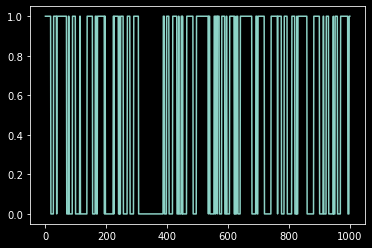

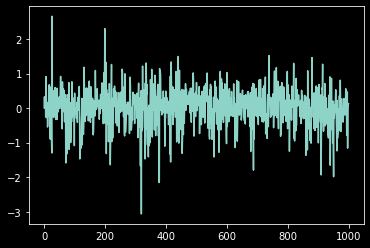

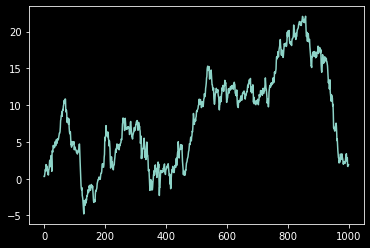

In [38]:
def simulate_hmm(n,A,P,means,covs):
    '''
    n: integer with the number of points to generate
    A: numpy (n_states,n_states) array with transition prob
    P: numpy (n_states,) array with init state prob
    means: list with len=n_states of numpy (n_states,) array with the means for each
        variable
    covs:list with len=n_states of numpy (n_states,n_states) array with the covariances
        for each variable
    '''	
    states=np.arange(A.shape[0],dtype=int)
    z=np.zeros(n,dtype=int)
    x=np.zeros((n,means[0].size))
    z[0]=np.random.choice(states,p=P)
    x[0]=np.random.multivariate_normal(means[z[0]],covs[z[0]])
    for i in range(1,n):
        z[i]=np.random.choice(states,p=A[z[i-1]])
        x[i]=np.random.multivariate_normal(means[z[i]],covs[z[i]])
    return x,z

n = 1000
A = np.array([[0.9,0.1],[0.1,0.9]])
P = np.array([0.5,0.5])
means = np.array([[-0.1],[0.1]])
covs =  np.array([[[0.5]],[[0.1]]])
x_hmm, z = simulate_hmm(n,A,P,means,covs)

plt.plot(z)
plt.show()

plt.plot(x_hmm[:,0])
plt.show()

plt.plot(np.cumsum(x_hmm[:,0]))
plt.show()


In [2]:
def simulate_trend_switch(n,A,a,s0,s1):
    '''
    '''	
    states = np.array([0,1],dtype = int)
    z = np.zeros(n, dtype=int)
    x = np.zeros(n, dtype=float)    
    z[0]=np.random.choice(states)
    if z[0] == 0:
        x[0] = np.random.normal(0, np.sqrt(s0))
    else:
        x[0] = np.random.normal(0, np.sqrt(s1))
        
    for i in range(1,n):
        z[i]=np.random.choice(states,p=A[z[i-1]])
        if z[i] == 0:
            x[i] = np.random.normal(0, np.sqrt(s0))
        else:
            x[i] = np.random.normal(0, np.sqrt(s1))
    return x,z


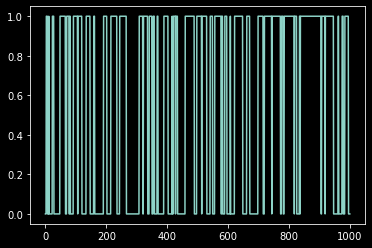

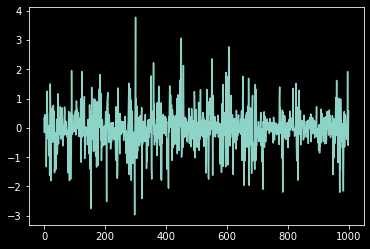

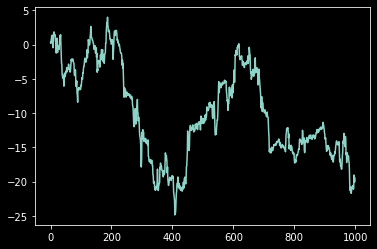

In [5]:
n = 1000
A = np.array([[0.9,0.1],[0.1,0.9]])
a = 0.1
s0 = 1
s1 = 0.1

x,z = simulate_trend_switch(n,A,a,s0,s1)
plt.plot(z)
plt.show()
plt.plot(x)
plt.show()
plt.plot(np.cumsum(x))
plt.show()
